# Машинное обучение, ПМИ ФКН ВШЭ

## ЕМ алгоритм и его приложения

В этом ноутбуке мы посмотрим на простейшее применение ЕМ-алгоритма &mdash; разделение смеси гауссиан. Но несмотря на кажущуюся простоту модели смеси гауссиан, ей можно найти применение на реальных данных. Мы будем решать задачу денойзинга выборки из нескольких исходных изображений.

**Внимание!** Для отрисовки видео требуется утилита `ffmpeg`

In [1]:
import os
import shutil
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import Video


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 16})

## 1. Разделение смеси гауссиан

Для начала сгенерируем двухмерные синтетические данные для визуализации оптимизации ELBO в ЕМ-алгоритме. Возьмем вероятности компонент смеси $\pi$ как сэмпл из распределения Дирихле (его носителем как раз является симплекс $\sum_k \pi_k = 1, \pi_k \ge 0$). Центры компонент возьмем нормальными $\mu_k \sim \mathcal{N}(0, I)$, а матрицы ковариаций сгенерируем как $\Sigma_k = LL^T, L_{ij} \sim \mathcal{N}(0, d^{-1})$, где $d$ - размерность пространства признаков.

Разные варианты распределения Дирихле:
![](https://habrastorage.org/getpro/habr/post_images/891/6ab/680/8916ab68010dac3bb199fa6c8bd2e70d.png)

In [2]:
from scipy.stats import dirichlet, norm, multivariate_normal


def generate_cluster_data(n_clusters=3, dim=100, n_samples=10000):
    pi = dirichlet.rvs(np.ones(n_clusters)).reshape(-1)
    mu = norm.rvs(size=(n_clusters, dim))
    sigma = norm.rvs(size=(n_clusters, dim, dim)) / np.sqrt(dim)
    sigma = sigma @ np.transpose(sigma, axes=(0, 2, 1))

    X, y = np.zeros((0, dim), dtype=np.float32), np.zeros(0, dtype=np.int)
    for i in range(n_clusters):
        count = n_samples - X.shape[0] if i == n_clusters - 1 else int(n_samples * pi[i])
        X_new = multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=count)
        X = np.concatenate([X, X_new])
        y = np.concatenate([y, np.full(count, fill_value=i, dtype=np.int)])

    perm = np.random.permutation(n_samples)
    X, y = X[perm], y[perm]
    return X, y, (pi, mu, sigma)

Сгенерируем выборку и нарисуем ее.

In [3]:
np.random.seed(0xBABA)
n_clusters = 3
X, y, (pi, mu, sigma) = generate_cluster_data(
    n_clusters=n_clusters, dim=2,
    n_samples=10000
)

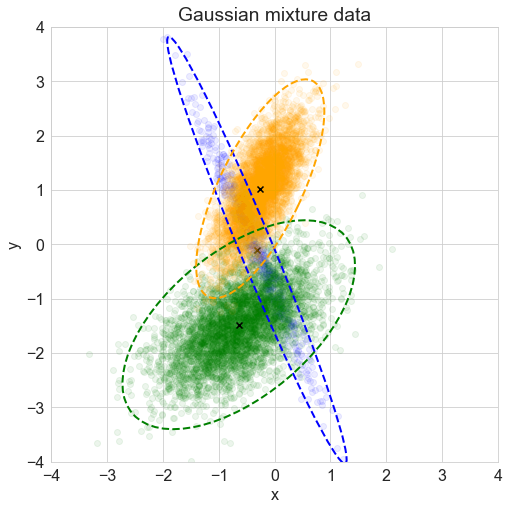

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = np.array(
    [np.array(mpl.colors.to_rgb(color)) \
    for color in ['blue', 'green', 'orange']]
)
n_std = 3

for i in range(n_clusters):
    plt.scatter(X[y == i, 0], X[y == i, 1], alpha=0.075, color=colors[i])
    plt.scatter(mu[i, 0], mu[i, 1], color='black', marker='x')

    vals, vecs = np.linalg.eigh(sigma[i])
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * n_std * np.sqrt(vals)
    ell = Ellipse(xy=mu[i], width=w, height=h, angle=theta,
                  edgecolor=colors[i], facecolor='none', linewidth=2,
                  linestyle='--')
    ax.add_artist(ell)

plt.title('Gaussian mixture data')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.show()

Вспомним, как выглядит вероятностная модель для смеси гауссиан и шаги ЕМ алгоритма для нее. Полное правдоподобие записывается так:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

Нижняя оценка правдоподобия (ELBO) вычисляется так:

$$
\mathcal{L}(g, \pi, \mu, \Sigma) = \sum_{i=1}^\ell \sum_{k=1}^K g_{ik} \Big[\log \pi_k + \log \mathcal{N}(x_i|\mu_k, \Sigma_k)\Big] - \sum_{i=1}^\ell \sum_{k=1}^K g_{ik} \log g_{ik}
$$

Обратите внимание, что для численной устойчивости в реализации сначала считаются логиты $g_i$, а потом величины $g_{ik}$ считаются через оператор Softmax. Точно так же используется библиотечная функция `scipy.special.xlogy`

In [5]:
from scipy.special import softmax, xlogy


def e_step(X, pi, mu, sigma):
    logits = np.zeros((X.shape[0], pi.shape[0]))
    for i in range(pi.shape[0]):
        if np.isscalar(sigma):
            logits[:, i] += norm.logpdf(X, mu[i], sigma).sum(axis=1)
        else:
            logits[:, i] += multivariate_normal.logpdf(X, mu[i], sigma[i])

    logits += np.log(pi).reshape(1, -1)
    g = softmax(logits, axis=1)
    return g


def m_step(X, g, scalar_sigma=None, reg_pi=0):
    pi = g.sum(axis=0) / g.shape[0] + reg_pi
    pi /= pi.sum()
    mu = (X.reshape(-1, 1, X.shape[1]) * g.reshape(-1, g.shape[1], 1)).sum(axis = 0) / \
         X.shape[0] / pi.reshape(pi.shape[0], 1)

    if scalar_sigma is not None:
        sigma = scalar_sigma
    else:
        X_mu = X.reshape(-1, 1, X.shape[1], 1) - mu.reshape(1, -1, mu.shape[1], 1)
        sigma = X_mu @ np.transpose(X_mu, (0, 1, 3, 2))
        sigma = (sigma * g.reshape(-1, g.shape[1], 1, 1)).sum(axis=0)
        sigma /= pi.reshape(-1, 1, 1) * X.shape[0]

    return pi, mu, sigma


def elbo(X, g, pi, mu, sigma):
    elbo_ = xlogy(g, pi.reshape(1, -1)).sum()
    for i in range(pi.shape[0]):
        if np.isscalar(sigma):
            elbo_ += (g[:, i] * norm.logpdf(X, mu[i], sigma).sum(axis=1)).sum()
        else:
            elbo_ += (g[:, i] * multivariate_normal.logpdf(X, mu[i], sigma[i])).sum()
    elbo_ -= xlogy(g, g).sum()
    return elbo_


def em_algorithm(X, n_clusters=3, n_iters=100, history=0,
                 tol=1e-6, scalar_sigma=None, reg_pi=0):
    g = np.full((X.shape[0], n_clusters), 1 / n_clusters)
    pi = np.ones(n_clusters) / n_clusters
    mu = norm.rvs(size=(n_clusters, X.shape[1]))
    if scalar_sigma is not None:
        sigma = scalar_sigma
    else:
        sigma = np.stack([np.eye(X.shape[1]) for _ in range(n_clusters)], axis=0)

    elbos = [] if history >= 1 else None
    trace = {'g': [], 'pi': [], 'mu': [], 'sigma': []} if history >= 2 else None

    if elbos is not None:
        elbos += [elbo(X, g, pi, mu, sigma)]

    if trace is not None:
        trace['g'] += [g]
        trace['pi'] += [pi]
        trace['mu'] += [mu]
        trace['sigma'] += [sigma]

    for i in tqdm(range(n_iters)):
        g = e_step(X, pi, mu, sigma)
        pi, mu, sigma = m_step(X, g, scalar_sigma=scalar_sigma, reg_pi=reg_pi)

        if trace is not None:
            trace['g'] += [g]
            trace['pi'] += [pi]
            trace['mu'] += [mu]
            trace['sigma'] += [sigma]
        
        if elbos is not None:
            elbos += [elbo(X, g, pi, mu, sigma)]
            if np.abs(elbos[-1] - elbos[-2]) < tol:
                break

    return (g, pi, mu, sigma), (elbos, trace)

In [6]:
(g, pi_hat, mu_hat, sigma_hat), (elbos, trace) = \
    em_algorithm(X, n_clusters=3, n_iters=40, history=2)

  0%|          | 0/40 [00:00<?, ?it/s]

ЕМ алгоритм гарантирует возрастание ELBO, поэтому нарисуем его и проверим, что это действительно так.

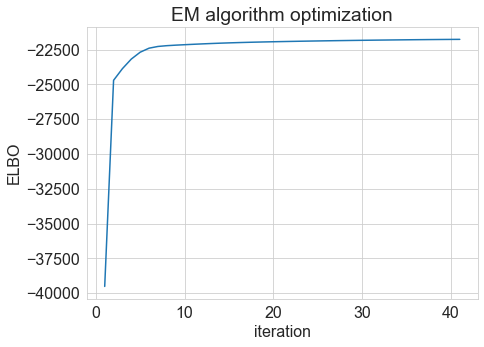

In [7]:
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, len(elbos) + 1), elbos)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.title('EM algorithm optimization')
plt.show()

Посмотрим, как менялись параметры по ходу оптимизации, а также, к каким кластерам алгоритм относил точки выборки.

In [8]:
def plot_samples(X, g, mu, sigma, iteration, filename):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    confidence = (g.reshape(-1, n_clusters, 1) * \
                  colors.reshape(1, n_clusters, -1)).sum(axis=1)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.075, c=confidence)

    for i in range(n_clusters):
        plt.scatter(mu[i, 0], mu[i, 1], color='black', marker='x')

        vals, vecs = np.linalg.eigh(sigma[i])
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        w, h = 2 * n_std * np.sqrt(vals)
        ell = Ellipse(xy=mu[i], width=w, height=h, angle=theta,
                      edgecolor=colors[i], facecolor='none', linewidth=2,
                      linestyle='--')
        ax.add_artist(ell)

    plt.title(f'Iteration: #{iteration}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.tight_layout()
    plt.savefig(filename)
    plt.close(fig)


def generate_em_video(X, trace):
    os.mkdir('plots')
    plt.ioff()
    for i in range(len(trace['g'])):
        plot_samples(X, trace['g'][i], trace['mu'][i],
                     trace['sigma'][i], i, f'plots/{i:03d}.jpg')
    plt.ion()

    subprocess.call([
        'ffmpeg', '-framerate', '3', '-i', 'plots/%03d.jpg', '-r', '30',
        '-pix_fmt', 'yuv420p', 'EM.mp4'
    ])
    shutil.rmtree('plots')

In [9]:
if os.path.isfile('EM.mp4'):
    os.remove('EM.mp4')
generate_em_video(X, trace)
Video('EM.mp4')

Сравним теперь модель смеси гауссиан и обычный KMeans. Сравнение, конечно, не очень честное, потому что мы знаем, как на самом деле распределены наши данные, но здесь мы можем убедиться в том, что ЕМ-алгоритм присваивает выборке мягкую разметку, $g_{i}$ показывает апостериорное распределение вероятностей кластеров для одного объекта.

In [10]:
from sklearn.cluster import KMeans

y_em = np.argmax(g, axis=1)
kmeans = KMeans(n_clusters=n_clusters).fit(X)
y_kmeans = kmeans.labels_

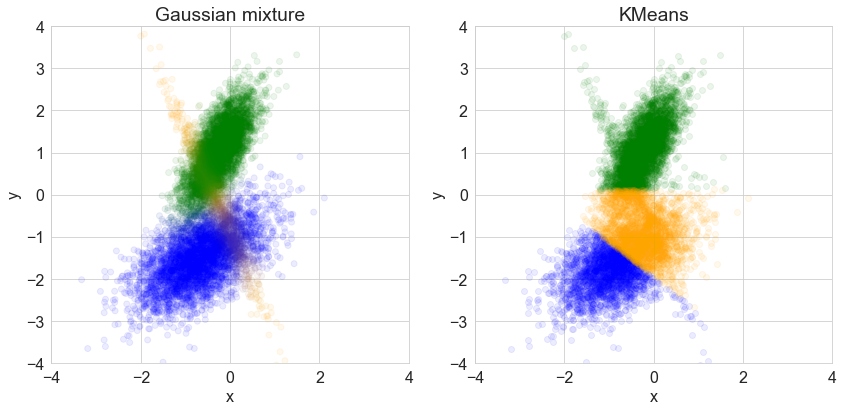

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

confidence = (g.reshape(-1, n_clusters, 1) * \
             colors.reshape(1, n_clusters, -1)).sum(axis=1)
axs[0].scatter(X[:, 0], X[:, 1], alpha=0.075, c=confidence)

for i in range(n_clusters):
    axs[1].scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], alpha=0.075, color=colors[i])

for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

axs[0].set_title('Gaussian mixture')
axs[1].set_title('KMeans')
plt.tight_layout()
plt.show()

## 2. Восстановление изображений с помощью смеси гауссиан

Теперь попробуем применить смесь гауссиан на реальных данных. Сформулируем задачу денойзинга изображений на вероятностном языке. Пусть у нас есть несколько исходных картинок, но мы наблюдаем только некоторую выборку из их зашумленных копий. При этом, мы не знаем, к какой исходной картинке относится каждая зашумленная копия. Задача проста &mdash; восстановить исходные изображения.

Мы можем думать об исходных изображениях как о центрах кластеров $\mu_k$ и попробовать найти их с помощью модели разделения гауссиан. Единственное, здесь мы будем пользоваться упрощенной моделью: будем считать матрицы ковариаций $\Sigma_k$ а) скалярными $\Sigma_k = \sigma_k I$, б) заранее известными ("знаем зашумленность канала передачи данных").

Загрузим картинки и попробуем добавить к ним нормальный щум с некоторой дисперсией.

In [22]:
%%bash
wget -qq https://pbs.twimg.com/profile_images/2841201098/8a4a2cb036ab647ee9dfb99d153289c7.jpeg -O 1.jpg
wget -qq https://a.ppy.sh/12197959_1550159341.jpeg -O 2.jpg
wget -qq https://pbs.twimg.com/profile_images/639245815488380929/om0LyvYC.jpg -O 3.jpg

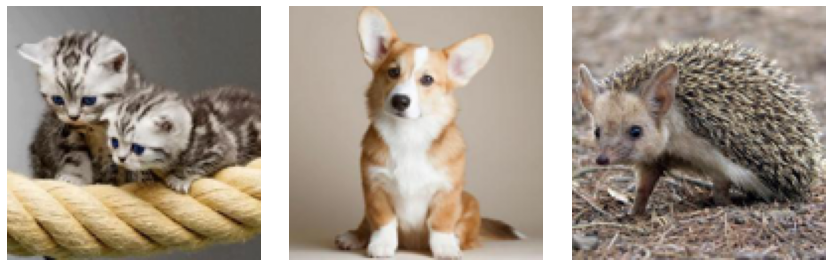

In [13]:
num_images = 3
img_size = 128
images = [np.asarray(Image.open(f'{i}.jpg').resize((img_size, img_size))) / 255. \
          for i in range(1, num_images + 1)]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axs[i].imshow(images[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
def normalize(image):
    return (image - 0.5) / 0.5

def denormalize(image):
    return image * 0.5 + 0.5

def generate_noisy_images(samples_per_image):
    noisy_images = []
    labels = []

    for i in range(num_images):
        noisy_images += [
            normalize(images[i]).reshape(1, -1) + \
            norm.rvs(size=(samples_per_image, images[i].size), scale=noise_scale)
        ]
        labels += [np.full(samples_per_image, i)]

    noisy_images = np.concatenate(noisy_images, axis=0)
    perm = np.random.permutation(num_images * samples_per_image)
    return noisy_images[perm]

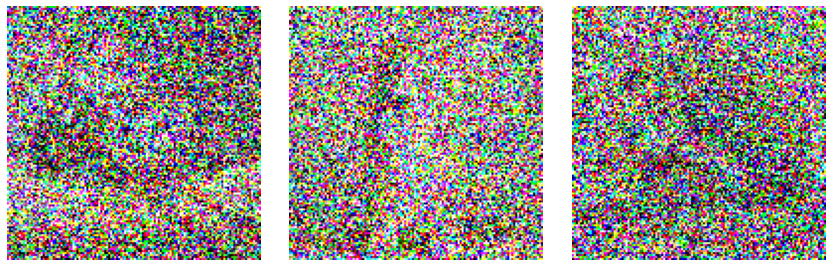

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
noise_scale = 2

for i in range(num_images):
    noisy_image = normalize(images[i]) + norm.rvs(size=images[i].shape, scale=noise_scale)
    axs[i].imshow(np.clip(denormalize(noisy_image), 0, 1))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Любопытно, что если взять небольшое число сэмплов на каждую исходную картинку, то в результате будут получаться эдакие мета-стабильные решения, которые объединяют несколько картинок.

In [16]:
np.random.seed(0x100)
noisy_images = generate_noisy_images(150)
(g, pi_hat, mu_hat, sigma_hat), (elbos, trace) = \
    em_algorithm(noisy_images, n_clusters=3, n_iters=10,
                 scalar_sigma=noise_scale, history=2, reg_pi=1e-8)

  0%|          | 0/10 [00:00<?, ?it/s]

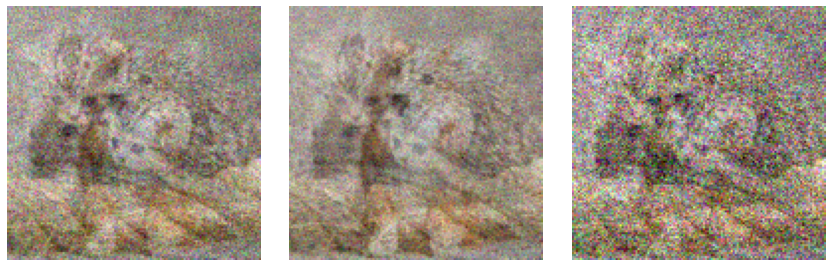

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i in range(num_images):
    image_rec = mu_hat[i].reshape(images[0].shape)
    axs[i].imshow(np.clip(denormalize(image_rec), 0, 1))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

При увеличении числа сэмплов картинки неплохо восстанавливаются.

In [18]:
np.random.seed(0x101)
noisy_images = generate_noisy_images(300)
(g, pi_hat, mu_hat, sigma_hat), (elbos, trace) = \
    em_algorithm(noisy_images, n_clusters=3, n_iters=10,
                 scalar_sigma=noise_scale, history=2, reg_pi=1e-8)

  0%|          | 0/10 [00:00<?, ?it/s]

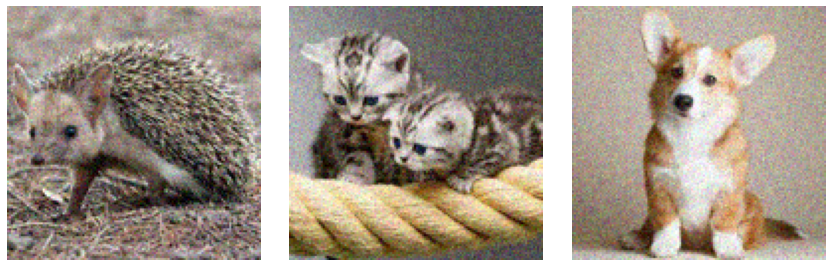

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i in range(num_images):
    image_rec = mu_hat[i].reshape(images[0].shape)
    axs[i].imshow(np.clip(denormalize(image_rec), 0, 1))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Посмотрим также, как менялись картинки по ходу оптимизации.

In [20]:
def plot_denoising(mu, iteration, filename):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4.5))

    for i in range(num_images):
        image_rec = mu[i].reshape(images[0].shape)
        axs[i].imshow(np.clip(denormalize(image_rec), 0, 1))
        axs[i].axis('off')

    axs[1].set_title(f'Iteration: #{iteration}')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close(fig)


def generate_rec_video(X, trace):
    os.mkdir('plots')
    plt.ioff()
    for i in range(len(trace['mu'])):
        plot_denoising(trace['mu'][i], i, f'plots/{i:03d}.jpg')
    plt.ion()

    subprocess.call([
        'ffmpeg', '-framerate', '1', '-i', 'plots/%03d.jpg', '-r', '10',
        '-pix_fmt', 'yuv420p', 'denoising.mp4'
    ])
    shutil.rmtree('plots')

In [21]:
if os.path.isfile('denoising.mp4'):
    os.remove('denoising.mp4')
generate_rec_video(X, trace)
Video('denoising.mp4')

Таким образом, решение находится всего за несколько итераций. Чтобы улучшить решение, можно использовать ЕМ-алгоритм с рестартами. Поскольку функционал ELBO невогнутый, то всякий раз будут получаться новые решения.